In [47]:
#load libraries

from skimage import io
import imageio as iio
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib
import sklearn
from sklearn import manifold
import time
import math

import scipy.sparse.linalg as ll
from sklearn import neighbors as sk_n
from sklearn.utils.graph import single_source_shortest_path_length
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import shortest_path
import random
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

# Loading and Preparing the Data

In [5]:
#read images. images are downloaded from Mendeley Data
#Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2

images_normal = list()
for file in Path("ChestXRay/chest_xray/NORMAL").iterdir():
    if not file.is_file():
        continue

    images_normal.append(iio.imread(file))
    
images_pneum = list()
for file in Path("ChestXRay/chest_xray/PNEUMONIA").iterdir():
    if not file.is_file():
        continue

    images_pneum.append(iio.imread(file))

C:\Users\aida_\AppData\Local\Temp\ipykernel_26224\2110116613.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_normal.append(iio.imread(file))
C:\Users\aida_\AppData\Local\Temp\ipykernel_26224\2110116613.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_pneum.append(iio.imread(file))


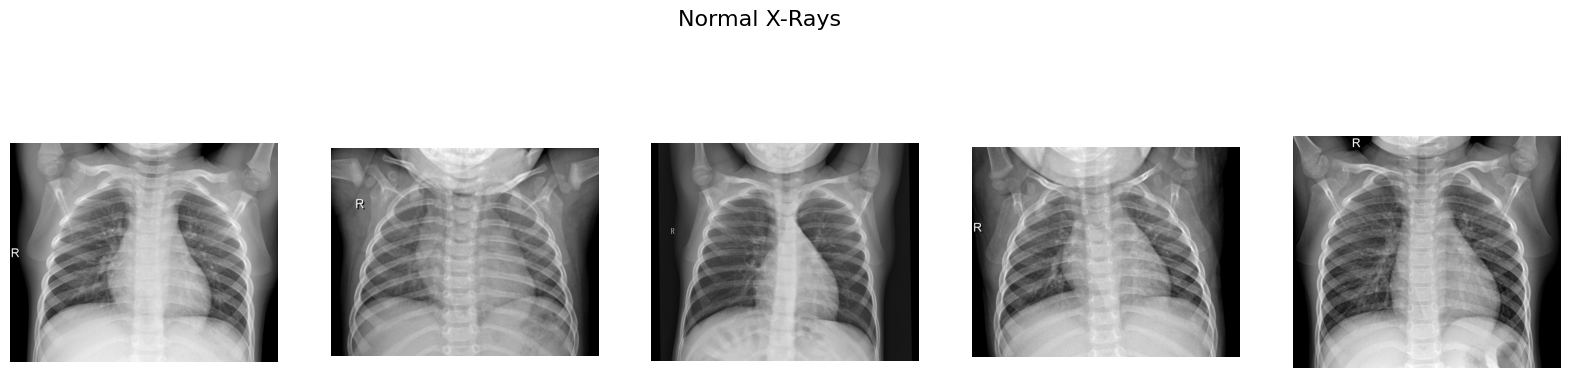

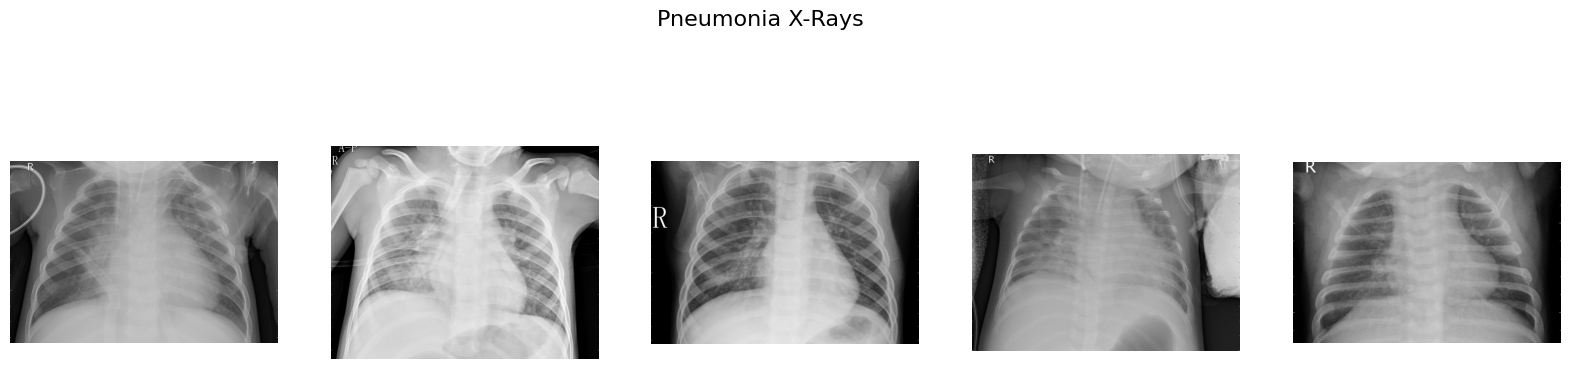

In [11]:
#show a sample of 5 images from both normal and pneumonia class

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for ax, img in zip(axes, random.sample(images_normal, 5)):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.suptitle('Normal X-Rays', fontsize=16)
    
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for ax, img in zip(axes, random.sample(images_pneum, 5)):
    ax.imshow(img, cmap='gray')
    ax.axis('off') 

plt.suptitle('Pneumonia X-Rays', fontsize=16)

plt.show()

At a glance, it is not that obvious which images are from a sick person and which are normal.

In the interest of faster processing I will shrink the images to 210x150 pixels size.

In [14]:
# Define the target size (width, height)
target_size = (210, 150) 

# Function to resize an image array
def resize_image_array(image_array, target_size):
    # Convert numpy array to PIL Image
    img = Image.fromarray(image_array)
    # Resize the image
    img_resized = img.resize(target_size, Image.LANCZOS)
    # Convert PIL Image back to numpy array
    return np.array(img_resized)

# Resize all images in the lists
resized_images_normal = [resize_image_array(img, target_size) for img in images_normal]
resized_images_pneum = [resize_image_array(img, target_size) for img in images_pneum]

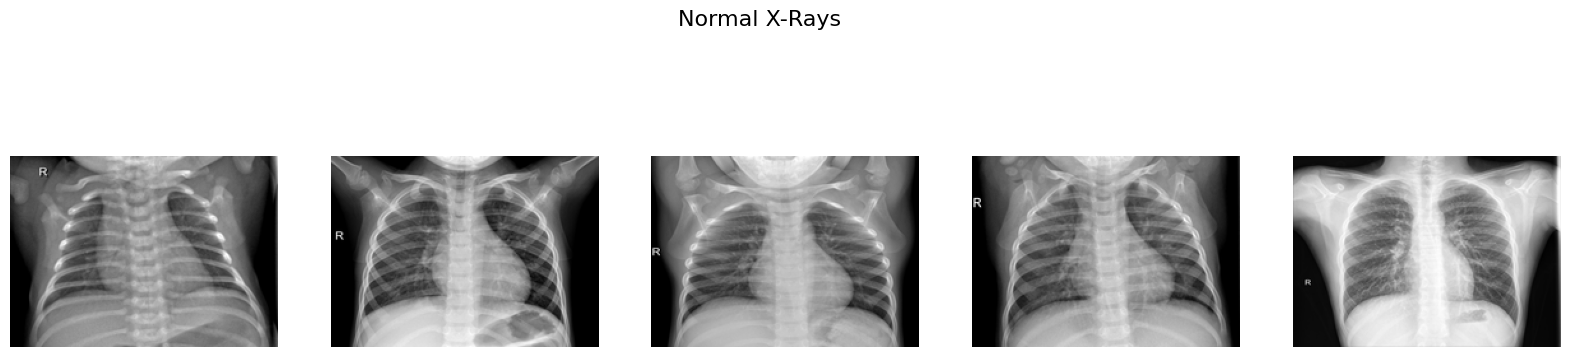

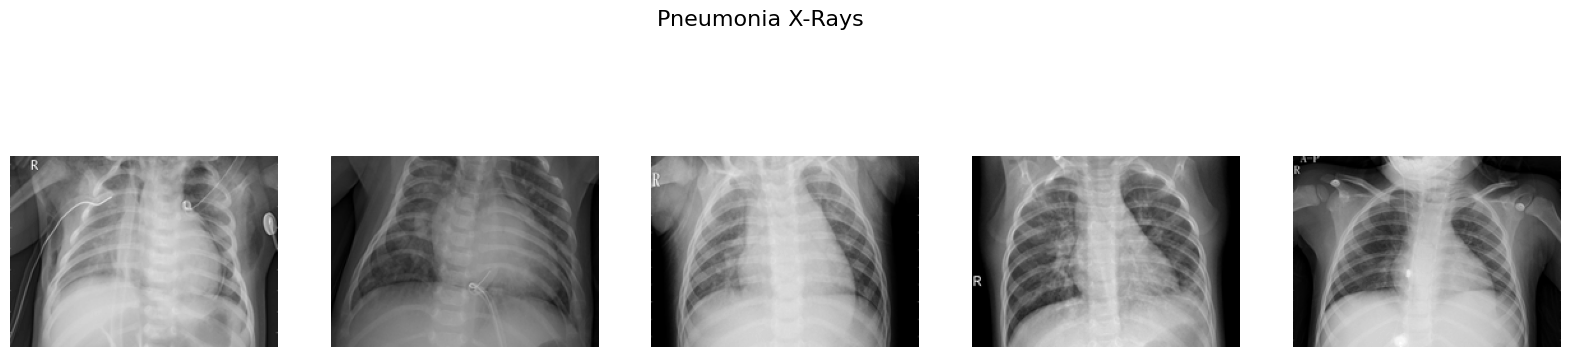

In [15]:
#visualize shrunk images

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for ax, img in zip(axes, random.sample(resized_images_normal, 5)):
    ax.imshow(img, cmap='gray')
    ax.axis('off')  # Hide the axes

plt.suptitle('Normal X-Rays', fontsize=16)

plt.show()

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for ax, img in zip(axes, random.sample(resized_images_pneum, 5)):
    ax.imshow(img, cmap='gray')
    ax.axis('off')  # Hide the axes

plt.suptitle('Pneumonia X-Rays', fontsize=16)

plt.show()

In [16]:
#flatten and label images
normal = list()
for i in resized_images_normal:
    flat = i.flatten()
    normal.append(flat)
normal_df = pd.DataFrame(np.vstack(normal))
normal_df["class"] = 0

pneum = list()
for i in resized_images_pneum:
    flat = i.flatten()
    pneum.append(flat)
    
pneum_df = pd.DataFrame(np.vstack(pneum))
pneum_df["class"] = 1

In [24]:
#concatenate in one data frame normal and pneumonia images
frames = [normal_df, pneum_df]
data = pd.concat(frames)
data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,31491,31492,31493,31494,31495,31496,31497,31498,31499,class
0,30,33,32,31,31,31,30,29,29,28,...,32,32,33,33,33,34,33,34,31,0
1,24,37,30,26,29,59,77,88,93,104,...,32,33,33,33,32,33,33,33,28,0
2,35,37,36,37,35,34,34,35,35,34,...,29,32,33,34,35,34,35,35,32,0
3,66,75,75,75,77,77,86,95,101,98,...,123,119,108,125,137,130,139,130,117,0
4,38,41,39,39,38,37,36,36,37,36,...,41,42,42,43,44,43,44,45,42,0
5,121,125,129,129,131,134,137,138,137,139,...,56,59,72,94,134,191,217,221,175,0
6,9,10,9,10,10,10,10,10,11,10,...,5,6,8,9,10,11,11,12,10,0
7,11,12,12,12,12,13,13,13,13,14,...,13,14,14,14,15,16,15,16,15,0
8,16,16,17,18,18,18,18,18,17,17,...,25,25,26,27,27,29,28,31,28,0
9,16,18,19,20,18,19,20,20,20,21,...,20,20,22,22,23,23,23,25,22,0


# Data Splitting and Dimensionality Reduction

In [25]:
#split data into train, test and validation

train, temp = train_test_split(data, test_size=0.3, random_state=1)
test, valid = train_test_split(temp, test_size=0.5, random_state=1)

print(train.shape, test.shape, valid.shape)
print(train.groupby(['class'])['class'].count())
print(test.groupby(['class'])['class'].count())
print(valid.groupby(['class'])['class'].count())


(3901, 31501) (836, 31501) (836, 31501)
class
0    1110
1    2791
Name: class, dtype: int64
class
0    249
1    587
Name: class, dtype: int64
class
0    224
1    612
Name: class, dtype: int64


### Dimensionality reduction: ISOMAP

ISOMAP is a good dimentionality reduction technique for non-linear data such as image data. It uses a manifold learning method based on the shortest path, which can preserve the global topological structure of data.

Below I am applying 2 and 3 component reduction to be able to vizualize the output.

In [26]:
#isomap 2d

iso = manifold.Isomap(n_components=2)
iso.fit(train.iloc[:,:31500])
manifold_2Da = iso.transform(train.iloc[:,:31500])
manifold_2D = pd.DataFrame(manifold_2Da)

In [27]:
color = train['class'].replace([0,1],['green','red']) #green - normal, red - sick

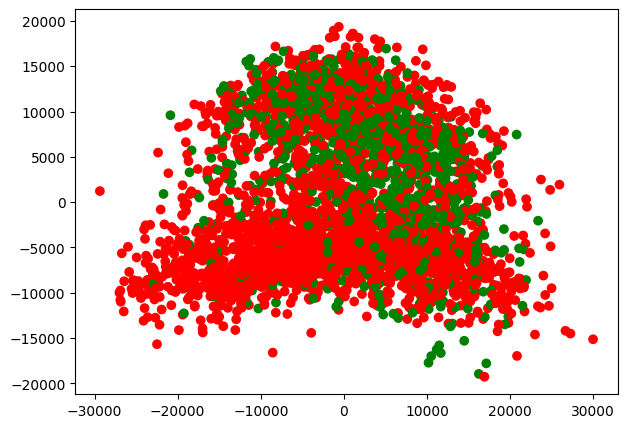

In [28]:
#plot
fig = plt.figure(figsize = (7, 5))
ax = plt.axes()

ax.scatter(manifold_2D.iloc[:,0],manifold_2D.iloc[:,1], c= color)
plt.show()

With 2 component isomap we do not see a clear distinction between normal and infected classes.

Building a 3 component ISOMAP.

In [29]:
#isomap 3d 
iso3 = manifold.Isomap(n_components=3)
iso3.fit(train.iloc[:,:31500])
manifold_3Da = iso3.transform(train.iloc[:,:31500])
manifold_3D = pd.DataFrame(manifold_3Da)

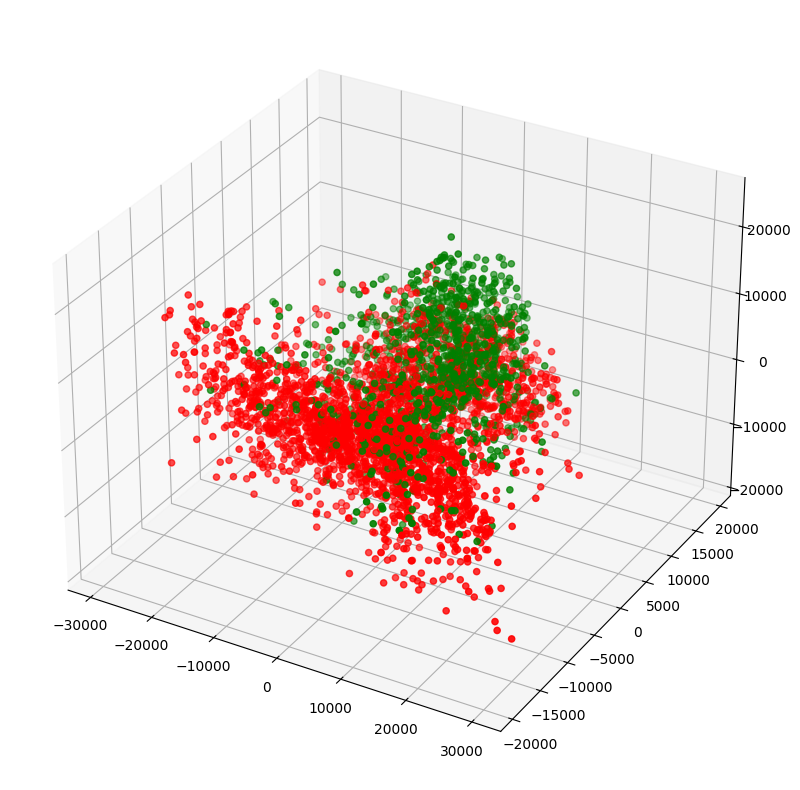

In [42]:
#vizualize 3d isomap from different angles
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ="3d")

ax.scatter3D(manifold_3D.iloc[:,0],manifold_3D.iloc[:,1],manifold_3D.iloc[:,2], c=color)

plt.show()

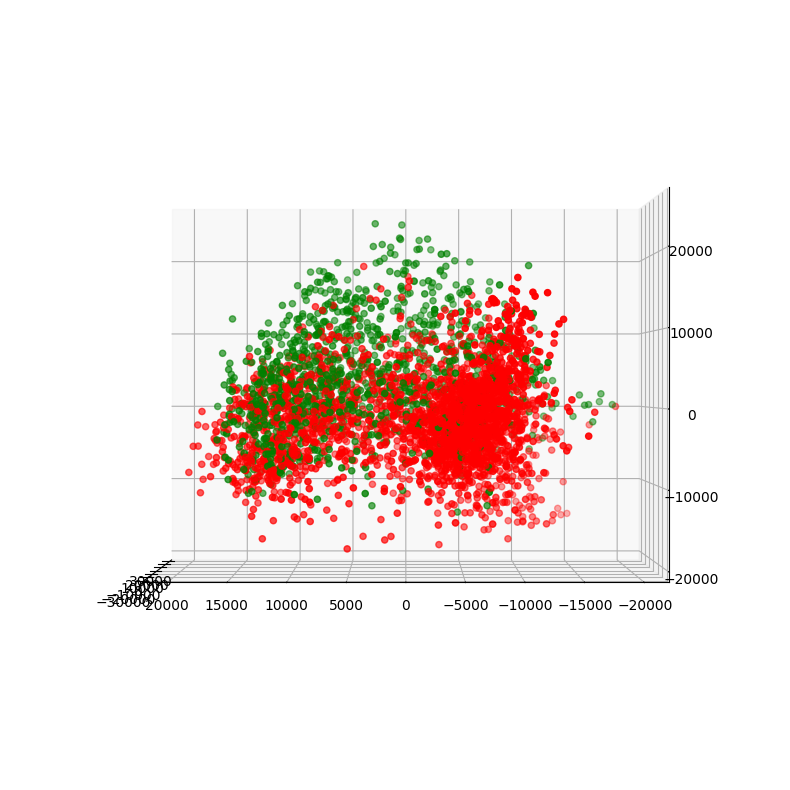

In [43]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ="3d")

ax.scatter3D(manifold_3D.iloc[:,0],manifold_3D.iloc[:,1],manifold_3D.iloc[:,2], c=color)

ax.azim = 180
ax.elev = 0

plt.show()

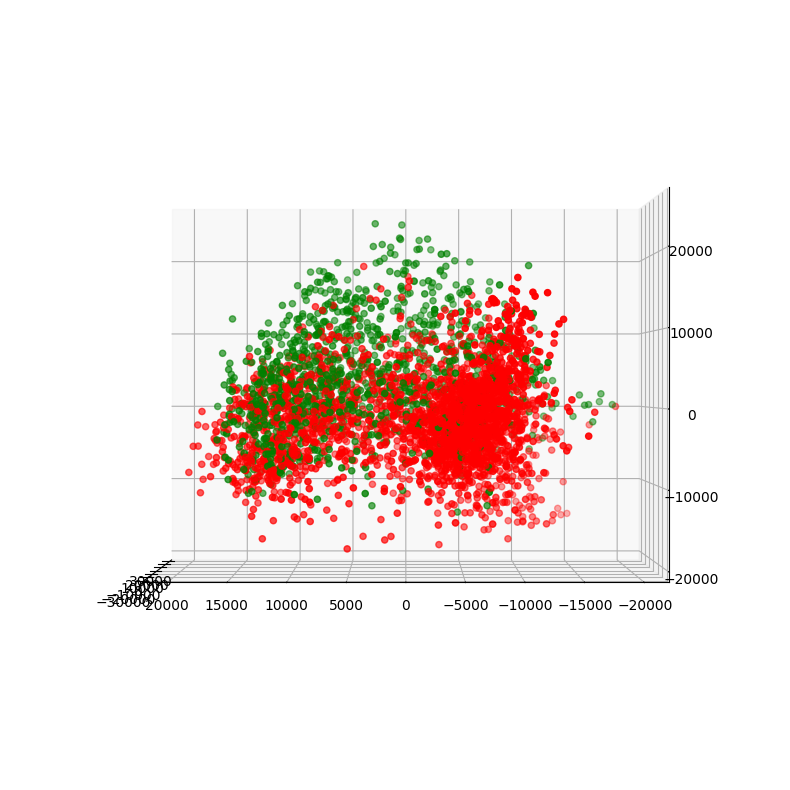

In [41]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ="3d")

ax.scatter3D(manifold_3D.iloc[:,0],manifold_3D.iloc[:,1],manifold_3D.iloc[:,2], c=color)

ax.azim = 180
ax.elev = 0

plt.show()

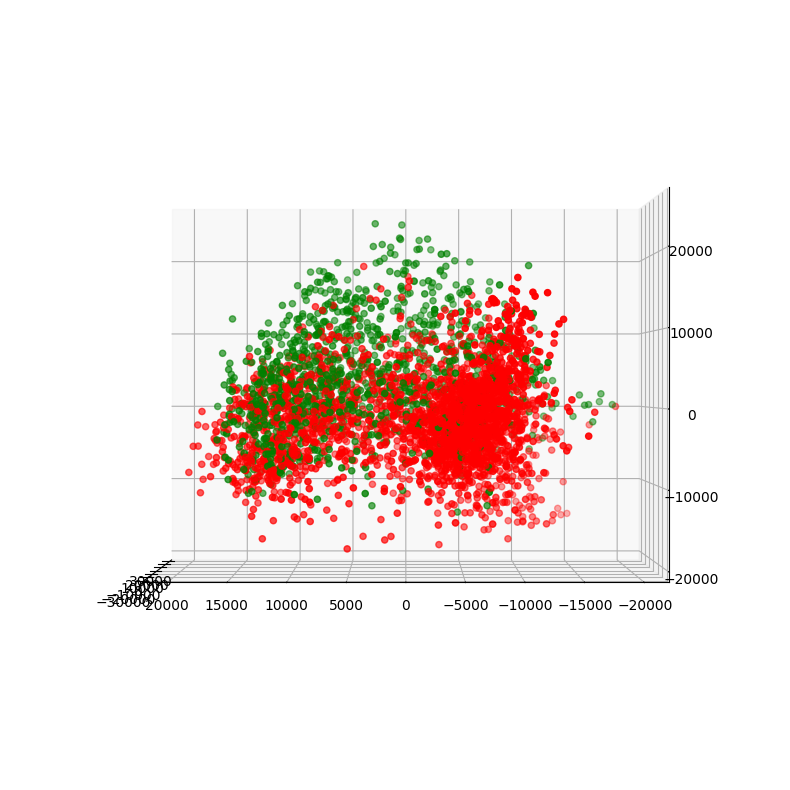

In [40]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ="3d")

ax.scatter3D(manifold_3D.iloc[:,0],manifold_3D.iloc[:,1],manifold_3D.iloc[:,2], c=color)

ax.azim = 180
ax.elev = 0

plt.show()

From the above visualizations I can conclude that ISOMAP does a reasonable job at grouping normal vs infected images in a 3d space.

# Classification: Traditional ML

Below I will attemp 2 classification algorithms: SVM and KNN. I will apply both to reduced dimensionality and the original image dataset.

### SVM on ISOMAP data

In [54]:
#fit SVM to 3d training data
tic = time.perf_counter()
  
svm_iso = SVC()
  
svm_iso.fit(manifold_3D, train['class'])

toc = time.perf_counter()
print(f"Time {toc - tic:0.4f} seconds")

Time 0.2058 seconds


In [69]:
#transform validation set for prediction
tic = time.perf_counter()

ISO_valid = iso3.transform(valid.iloc[:,:31500])
toc = time.perf_counter()

print(f"Time {toc - tic:0.4f} seconds")

Time 2.1497 seconds


In [57]:
svm_iso_predictions = svm_iso.predict(ISO_valid)
  
# print classification report
print(classification_report(valid['class'], svm_iso_predictions))

              precision    recall  f1-score   support

           0       0.71      0.44      0.54       224
           1       0.82      0.93      0.87       612

    accuracy                           0.80       836
   macro avg       0.76      0.69      0.71       836
weighted avg       0.79      0.80      0.78       836



In [58]:
print("Overall accuracy: ", accuracy_score(valid['class'], svm_iso_predictions))

Overall accuracy:  0.8002392344497608


With this model I get 80% overall accuracy. 82% precision and 93% recall on the positive class. 

Model fitting and transformation took ~2.2sec.

## SVM on Original Image Data

In [59]:
#fit SVM to original training data
tic = time.perf_counter()
  
svm_or = SVC()
svm_or.fit(train.iloc[:,:31500], train['class'])

toc = time.perf_counter()
print(f"Time {toc - tic:0.4f} seconds")


Time 84.1471 seconds


In [109]:
svm_or_predictions = svm_or.predict(valid.iloc[:,:31500])
  
# print classification report
print(classification_report(valid['class'], svm_or_predictions))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       242
           1       0.96      0.98      0.97       594

    accuracy                           0.95       836
   macro avg       0.95      0.93      0.94       836
weighted avg       0.95      0.95      0.95       836



In [110]:
print("Overall accuracy: ", accuracy_score(valid['class'], svm_or_predictions))

Overall accuracy:  0.9521531100478469


Model built on original dataset gives a 95% accuracy. 98% recall and 96% precision on the positive class.

This model is notably slower given the number of dimensions. It took about 84 sec for the model to train.

## SVM on 10 ISOMAP components

In [62]:
#isomap 10
tic = time.perf_counter()

iso10 = manifold.Isomap(n_components=10)
iso10.fit(train.iloc[:,:31500])
manifold_10Da = iso10.transform(train.iloc[:,:31500])
manifold_10D = pd.DataFrame(manifold_10Da)
toc = time.perf_counter()

print(f"Time {toc - tic:0.4f} seconds")

Time 20.6391 seconds


In [63]:
tic = time.perf_counter()
  
svm_iso10 = SVC()
  
# fitting the model for grid search
svm_iso10.fit(manifold_10D, train['class'])

toc = time.perf_counter()
print(f"Time {toc - tic:0.4f} seconds")

Time 0.1375 seconds


In [68]:
ISO_valid10 = iso10.transform(valid.iloc[:,:31500])
svm_iso_predictions = svm_iso10.predict(ISO_valid10)
  
# print classification report
print(classification_report(valid['class'], svm_iso_predictions))

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       224
           1       0.91      0.96      0.93       612

    accuracy                           0.90       836
   macro avg       0.89      0.84      0.86       836
weighted avg       0.90      0.90      0.90       836



A 10 component ISOMAP gives notably stronger results. With 90% accuracy and 96% recall. It takes about 21 sec to train this model and run tranformation.

### KNN on 3D ISOMAP data

In [66]:
tic = time.perf_counter()
knn_iso = KNeighborsClassifier()

#Fit the model
knn_iso = knn_iso.fit(manifold_3D, train['class'])

toc = time.perf_counter()
print(f"Time {toc - tic:0.4f} seconds")

Time 0.0115 seconds


In [70]:
knn_iso_predictions = knn_iso.predict(ISO_valid)
  
# print classification report
print(classification_report(valid['class'], knn_iso_predictions))

              precision    recall  f1-score   support

           0       0.64      0.54      0.59       224
           1       0.84      0.89      0.87       612

    accuracy                           0.80       836
   macro avg       0.74      0.72      0.73       836
weighted avg       0.79      0.80      0.79       836



In [71]:
print("Overall accuracy: ", accuracy_score(valid['class'], knn_iso_predictions))

Overall accuracy:  0.7966507177033493


### KNN on Original Image data

In [72]:
tic = time.perf_counter()
#Create new KNN object
knn_or = KNeighborsClassifier()

knn_or = knn_or.fit(train.iloc[:,:31500], train['class'])

toc = time.perf_counter()
print(f"Time {toc - tic:0.4f} seconds")

knn_or_predictions = knn_or.predict(valid.iloc[:,:31500])
  
# print classification report
print(classification_report(valid['class'], knn_or_predictions))

print("Overall accuracy: ", accuracy_score(valid['class'], knn_or_predictions))

Time 0.5061 seconds
              precision    recall  f1-score   support

           0       0.91      0.69      0.78       224
           1       0.90      0.97      0.93       612

    accuracy                           0.90       836
   macro avg       0.90      0.83      0.86       836
weighted avg       0.90      0.90      0.89       836

Overall accuracy:  0.8983253588516746


KNN algorithm is noticeably faster, however it doesn't perform as well as SVM.

Let's assume that since this is medical data, which tends to be highly sensitive towards misclassifications on a positive (infected) class, accuracy and recall are of a higher priority comparing to processing times. With this in mind, SVM model trained on original image data is the winning model.

In [73]:
svm_or_predictions = svm_or.predict(test.iloc[:,:31500])
  
# print classification report
print(classification_report(test['class'], svm_or_predictions))

print("Overall accuracy: ", accuracy_score(test['class'], svm_or_predictions))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       249
           1       0.96      0.98      0.97       587

    accuracy                           0.96       836
   macro avg       0.96      0.95      0.95       836
weighted avg       0.96      0.96      0.96       836

Overall accuracy:  0.9629186602870813


Test set accuracy is 96%. Recall on a positive class is 98%.

# Classification: Open source pre-trained Vision Transformer

Next, I am going to apply an open source pre-trained model from Hugging Face (https://huggingface.co/lxyuan/vit-xray-pneumonia-classification) to my test data set. This model is a fine-tuned version of google/vit-base-patch16-224-in21k on the chest-xray-classification dataset. Original Vision Transformer model was pre-trained on 14 million images with 21,843 classes at resolution 224x224.

In [74]:
#make sure pytorch and tensorflow are installed as the below script is going to call them

#testing pretrained model on a random image from the internet
from transformers import pipeline

classifier = pipeline(model="lxyuan/vit-xray-pneumonia-classification")

# image taken from https://www.news-medical.net/health/What-is-Viral-Pneumonia.aspx
classifier("https://d2jx2rerrg6sh3.cloudfront.net/image-handler/ts/20200618040600/ri/650/picture/2020/6/shutterstock_786937069.jpg")

[{'label': 'PNEUMONIA', 'score': 0.990334689617157},
 {'label': 'NORMAL', 'score': 0.009665313176810741}]

The model takes images as an input

In [77]:
#converting arrays to images and creating a dataframe
df_norm = pd.DataFrame({
    'Image': [Image.fromarray(img) for img in resized_images_normal],
    'Class': 'NORMAL'
})

df_pneum = pd.DataFrame({
    'Image': [Image.fromarray(img) for img in resized_images_pneum],
    'Class': 'PNEUMONIA'
})

data = pd.concat([df_norm,df_pneum])
data.reset_index(drop=True, inplace=True)

In [79]:
#setting up a function to classify images and pick the highest score class
def classify(x):
    max_value = float('-inf')
    selected_value = None
    
    for dictionary in classifier(x):
        if dictionary['score'] > max_value:
            max_value = dictionary['score']
            selected_value = dictionary['label']
    
    return selected_value

In [80]:
#assuming this is unseen data, I do train / test split to simply reduce the sample size
train, test = train_test_split(data, test_size=0.2, random_state=1)

In [81]:
tic = time.perf_counter()
test['predicted'] = test['Image'].apply(classify)
toc = time.perf_counter()

print(f"Time {toc - tic:0.4f} seconds")

print(classification_report(test['Class'],test['predicted']))

print("Overall accuracy: ", accuracy_score(test['Class'],test['predicted']))

Time 390.2143 seconds
              precision    recall  f1-score   support

      NORMAL       0.93      0.97      0.95       315
   PNEUMONIA       0.99      0.97      0.98       857

    accuracy                           0.97      1172
   macro avg       0.96      0.97      0.96      1172
weighted avg       0.97      0.97      0.97      1172

Overall accuracy:  0.9718430034129693


The result from the open-source model was slightly stronger in term of overall accuracy (by 1%), however the recall was lower (by 1%). The open source model took 390 sec to predict on a test set.

The selection of the model will depend on the business priority. There is a model that saves processing time, one that maximizes accuracy, and one that maximizes recall. Given the nature of medical problems (false positives are better than false negatives), I will assume that recall is of a higher priority. The difference in the performance of NN model and the Traditional model is not very significant, therefore a traditional SVM can be used for this particular classification problem.